In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.style.use("ggplot")

In [2]:
g = nx.read_gml("../data/clean/all_routes.gml")

In [3]:
def get_nodes_by_type(g: nx.Graph, type:str) -> List[str]:
    return [city for city, typ in nx.get_node_attributes(g, "type").items() if typ == type]

def get_edges_by_type(g:nx.Graph, edge_type:str) -> List[Tuple[str, str]]:
    return [edge for edge, type in nx.get_edge_attributes(g, "type").items() if type == edge_type]

def get_neighbors_by_type(g:nx.Graph, location:str, type:str) -> List[str]:
    neighbors = []
    if type != "City" and type != "Airport" and type != "Station":
        raise ValueError(f"Unvalid type '{type}'")
    for node in g.adj[location]:
        if g.nodes[node]["type"] == type:
             neighbors.append(node) 
    return neighbors

def get_airplane_duration(g: nx.Graph, source_city:str, destination_city:str, airport_wait_minutes = 120) -> List[Dict[List[str], int]]:
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Airport")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Airport")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_airport, destination_airport in possible_coombinations:
        route = {
            "nodes": [source_city, source_airport, destination_airport, destination_city],
            "duration": 0
        }
        route["duration"] += g[source_city][source_airport]["duration"]
        route["duration"] += g[source_airport][destination_airport]["duration"]
        route["duration"] += g[destination_airport][destination_city]["duration"]
        route["duration"] += airport_wait_minutes
        durations.append(route)
    return durations


def get_car_duration(g: nx.Graph, source_city:str, destination_city:str) -> List[Dict[List[str], int]]:
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    route = {
        "nodes": [source_city, destination_city],
        "duration": g[source_city][destination_city]["duration"]
    }
    
    return [route]

def get_train_duration(g: nx.Graph, source_city:str, destination_city:str, train_wait_minutes = 10) -> List[Dict[List[str], int]]:
    def filter_train_edges(n1, n2):
        type =  g[n1][n2].get("type", "none")
        return type == "train"
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
        
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Station")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Station")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_station, destination_station in possible_coombinations:
        route = {
            "nodes": [source_city],
            "duration": 0
        }
        subgraph = nx.subgraph_view(g, filter_edge=filter_train_edges)
        shortest_path = nx.shortest_path(subgraph, source=source_station, target=destination_station, weight="duration")
        route["nodes"] += shortest_path + [destination_city]
        route["duration"] = nx.path_weight(g, shortest_path, "duration")
        route["duration"] += g[source_city][source_station]["duration"]
        route["duration"] += g[destination_city][destination_station]["duration"]
        durations.append(route)  
    return durations

def calculate_distance(lat1, lon1, lat2, lon2) -> int:
    earth_radius = 6371e3
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)

    a = (math.sin(delta_lat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(delta_lon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return round(earth_radius * c)

In [4]:
def build_coombinations(l: List[str]):
    for i, node1 in enumerate(l):
        for j in range(i+1,len(l)):
                yield (l[i], l[j])


def get_durations_by_transport_type(g:nx.Graph, type:str, weight="duration")-> List[int]:
    # Get all car durations
    nodes = get_nodes_by_type(g, type)
    durations = []
    coombinations = build_coombinations(nodes)
    if type == "City" or "Airport":
        for source, dest in tqdm.tqdm(coombinations):
            durations.append(g[source][dest].get(weight, None))
    else:
        for source, dest in tqdm.tqdm(coombinations):
            try:
                durations.append(nx.shortest_path_length(g, source, dest, "duration"))
            except:
                pass
    return durations



In [5]:
cities = get_nodes_by_type(g, "City")
possible_routes = build_coombinations(cities)
car_duration = []
plane_duration = []
train_duration = []
air_distances = []

for source, dest in tqdm(possible_routes):
    
    car_duration.append(get_car_duration(g, source, dest)[0]["duration"])
    plane_duration.append(get_airplane_duration(g, source, dest)[0]["duration"])
    train_duration.append(get_train_duration(g, source, dest)[0]["duration"])
    
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]
    air_distances.append(calculate_distance(lat1, lng1, lat2, lng2))

car_duration = np.array(car_duration)
plane_duration = np.array(plane_duration)
train_duration = np.array(train_duration)

train_plain_ratio = np.array(train_duration) / np.array(plane_duration)
car_plane_ratio = np.array(car_duration) / np.array(plane_duration) 
train_car_ratio = np.array(train_duration) / np.array(car_duration) 
air_distances = np.array(air_distances)

11175it [00:24, 452.80it/s]


## How much faster is it to travel by plane than car/train

Trains are faster than planes 5.67 % of the time
Cars are faster than planes 5.49 % of the time
Trains are faster than cars 48.43 % of the time


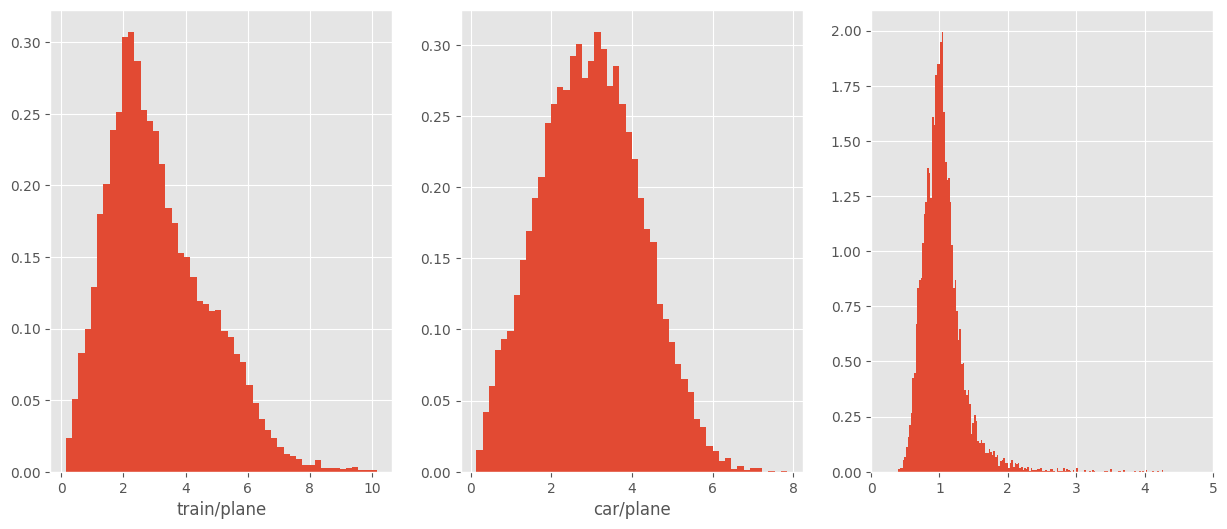

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].hist(train_plain_ratio, bins=50, density=True)
print("Trains are faster than planes",round(sum(train_plain_ratio < 1) / len(train_plain_ratio) * 100, 2), "% of the time")
ax[1].hist(car_plane_ratio, bins=50, density=True)
print("Cars are faster than planes", round(sum(car_plane_ratio < 1) / len(train_plain_ratio) * 100, 2), "% of the time")
ax[2].hist(train_car_ratio, bins=500, density=True)
print("Trains are faster than cars", round(sum(train_car_ratio < 1) / len(train_plain_ratio) * 100, 2), "% of the time")
ax[0].set_xlabel("train/plane")
ax[2].set_xlim(0,5)
ax[1].set_xlabel("car/plane")
plt.show()

TODO:
- bin the results and calculate their average
- plot the bined average results

In [7]:
data = {
    "car_duration": car_duration,
    "plane_duration": plane_duration,
    "train_duration": train_duration,
    "train_plane_ratio": train_plain_ratio,
    "car_plane_ratio": car_plane_ratio,
    "train_car_ratio": train_car_ratio,
    "distances": air_distances
}
df = pd.DataFrame(data = data)

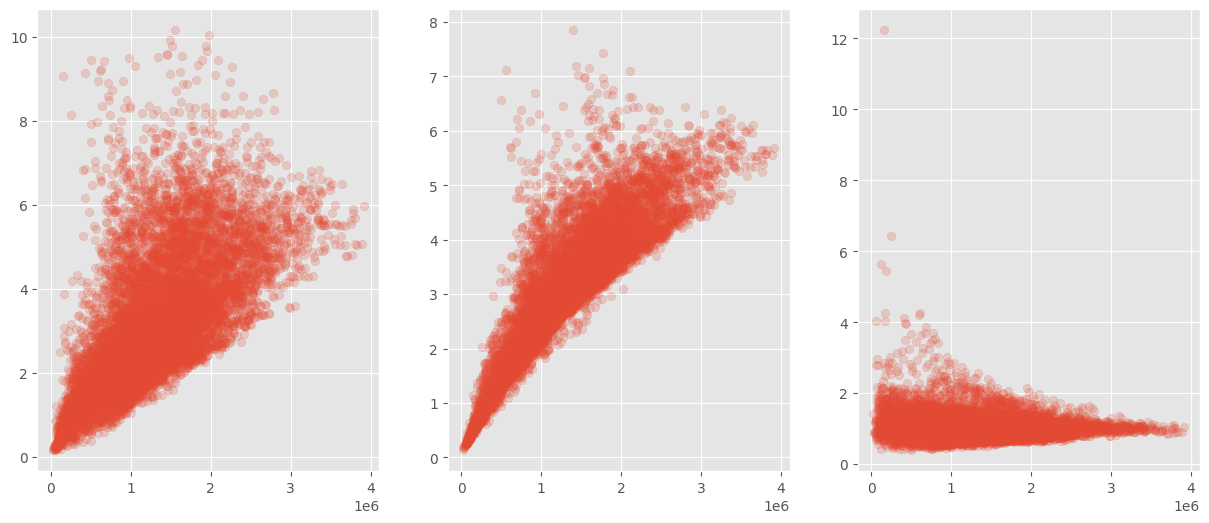

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].scatter(air_distances, train_plain_ratio, alpha=0.2)
ax[1].scatter(air_distances, car_plane_ratio, alpha=0.2)
ax[2].scatter(air_distances, train_car_ratio, alpha=0.2)
plt.show()

## Which routes have a low/high travel speed?
TODO:
- Add route visualisations
- Maybe add more then bottom/top 10 routes

In [9]:
possible_routes = build_coombinations(cities)

ratios = []

for source, dest in possible_routes:
    duration = get_car_duration(g, source, dest)[0]["duration"]
    distance = g[source][dest]["distance"]
    ratio = distance / duration * 60 
    ratios.append((ratio, (source, dest)))
sorted_paths = sorted(ratios, key= lambda x: x[0])
slowest_paths = sorted_paths[0:10]
fastest_paths = sorted_paths[-10:]

print("Slow routes")
for speed, route in slowest_paths:
    source, dest = route
    print(f"from: '{source}' to '{dest}' with an avg speed of: {round(speed,2)}")
print()
print("Fast routes")
for speed, route in fastest_paths:
    source, dest = route
    print(f"from: '{source}' to '{dest}' with an avg speed of: {round(speed,2)}")

Slow routes
from: 'Aalborg' to 'Gothenburg' with an avg speed of: 32.42
from: 'Turku' to 'Stockholm' with an avg speed of: 33.95
from: 'Helsinki' to 'Stockholm' with an avg speed of: 43.69
from: 'Vilnius' to 'Stockholm' with an avg speed of: 44.24
from: 'Kaunas' to 'Stockholm' with an avg speed of: 44.87
from: 'Bergen' to 'Stavanger' with an avg speed of: 45.05
from: 'Aarhus' to 'Gothenburg' with an avg speed of: 45.29
from: 'Brest' to 'Cork' with an avg speed of: 45.41
from: 'Brest' to 'Bristol' with an avg speed of: 47.35
from: 'Aalborg' to 'Turku' with an avg speed of: 49.81

Fast routes
from: 'Faro' to 'Santiago de Compostela' with an avg speed of: 108.64
from: 'Porto' to 'Barcelona' with an avg speed of: 108.71
from: 'Nantes' to 'Girona' with an avg speed of: 108.87
from: 'Alicante' to 'Asturias' with an avg speed of: 108.88
from: 'Porto' to 'Girona' with an avg speed of: 108.97
from: 'Nantes' to 'Toulouse' with an avg speed of: 109.01
from: 'Porto' to 'Bilbao' with an avg speed o

## What is the fastest?
### Which car routes are the fastest

In [10]:
possible_routes = build_coombinations(cities)
possible_routes = np.array(list(possible_routes))

In [11]:
mask = (car_duration < plane_duration) & (car_duration < train_duration)
print("Car are the fastes in: ",sum(mask) / len(mask) * 100)
fastest_car_routes = possible_routes[mask]
fastest_car_routes[0:10]

Car are the fastes in:  3.275167785234899


array([['Graz', 'Klagenfurt'],
       ['Graz', 'Linz'],
       ['Graz', 'Salzburg'],
       ['Graz', 'Vienna'],
       ['Graz', 'Rijeka'],
       ['Graz', 'Zagreb'],
       ['Graz', 'Brno'],
       ['Graz', 'Munich'],
       ['Graz', 'Budapest'],
       ['Graz', 'Trieste']], dtype='<U22')

### Which train routes are the fastest

In [12]:
mask = (train_duration < plane_duration) & (train_duration < car_duration)
print("Trains are the fastes in: ",sum(mask) / len(mask) * 100)
fastest_train_routes = possible_routes[mask]
fastest_train_routes[0:10]

Trains are the fastes in:  3.7315436241610738


array([['Innsbruck', 'Linz'],
       ['Innsbruck', 'Vienna'],
       ['Innsbruck', 'Karlsruhe'],
       ['Innsbruck', 'Munich'],
       ['Innsbruck', 'Nuremberg'],
       ['Linz', 'Salzburg'],
       ['Linz', 'Vienna'],
       ['Linz', 'Brno'],
       ['Linz', 'Memmingen'],
       ['Linz', 'Munich']], dtype='<U22')

### Which plain routes are the fastest?

In [13]:
mask = (plane_duration < train_duration) & (plane_duration < car_duration)
print("Plains are the fastes in: ",sum(mask) / len(mask) * 100)
fastest_plain_routes = possible_routes[mask]
fastest_plain_routes[0:10]

Plains are the fastes in:  92.97539149888144


array([['Graz', 'Innsbruck'],
       ['Graz', 'Antwerp'],
       ['Graz', 'Brussels'],
       ['Graz', 'Charleroi'],
       ['Graz', 'Liege'],
       ['Graz', 'Ostend'],
       ['Graz', 'Sofia'],
       ['Graz', 'Varna'],
       ['Graz', 'Prague'],
       ['Graz', 'Aalborg']], dtype='<U22')

# Possible Questions
 - At what distance is it more efffective to travel by car/train than ride a plane?
 - What is the average speed of cars/planes
     - Are there any paths with a really low/high average speeds?
 - What are the distributions of car/plane/train durations
     - How much longer does it take to travel by train than car/train  
 - What are the longest routes in europe
 - What is the best way to travel from A to B (chose some locations)
 - What is the average distance from the city to the airport? Same for station to airport?
 - What is the average distance between airports in a country
 - What is the average travel time inside countries?